# XGBoost model

In [1]:
import pandas as pd
import numpy as np
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

import modify_dataset as md

In [2]:
#Common error function to minimize: Root Mean Square Percentage Error
#We will have to integrate our loss function with xgboost

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


In [3]:
df = pd.read_csv("dataset/preprocessed_train.csv")

In [4]:
# removing all rows for which store is closed
df = df[df.IsOpen == 1]

df.drop(['NumberOfCustomers','Date'], axis=1, inplace=True)
#df = df.drop(['Region','Events'], axis=1)
# I could leave events

In [5]:
#for now let's drop unusable categorical vars
df.drop(['StoreType','AssortmentType','Events'], axis=1, inplace=True)

In [6]:
df.head().T

,0,1,2,3,5
StoreID,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
IsHoliday,0.000000,0.000000,0.000000,0.000000,0.000000
IsOpen,1.000000,1.000000,1.000000,1.000000,1.000000
HasPromotions,0.000000,0.000000,0.000000,0.000000,1.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000
NumberOfSales,5676.000000,8111.000000,8300.000000,7154.000000,10110.000000
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000


In [7]:
df.shape

(433958, 51)

In [8]:
train = md.get_fake_train(df)

In [9]:
train.shape

(397047, 51)

In [10]:
test = md.get_fake_test(df)
test.shape

(36911, 51)

In [11]:
#print("Load the training, test and store data using pandas")
#train = pd.read_csv("train.csv",low_memory=False)
#test = pd.read_csv("test.csv")
#store = pd.read_csv("store.csv")

### Selecting predictive features 

In [12]:
train.head(10).T

,0,1,2,3,5,6,7,8,9,10
StoreID,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
IsHoliday,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IsOpen,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
HasPromotions,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
NumberOfSales,5676.000000,8111.000000,8300.000000,7154.000000,10110.000000,9019.000000,8804.000000,7823.000000,7989.000000,5895.000000
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000


In [13]:
from pprint import pprint
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('IsOpen')
#features.remove('Region')
#features.remove('Region_GDP')
#features.remove('Max_Dew_PointC')
features.remove('Min_Dew_PointC')
features.remove('Max_Wind_SpeedKm_h')
features.remove('Max_VisibilityKm')
#features.remove('Min_Sea_Level_PressurehPa')
#features.remove('Precipitationmm')
#features.remove('Mean_Dew_PointC')
#features.remove('Min_TemperatureC')
features.remove('D_DayOfweek')
features.remove('Events_Thunderstorm')
features.remove('Events_Fog')
print("features")

pprint(features)

features
['IsHoliday',
 'HasPromotions',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'CloudCover',
 'Max_Dew_PointC',
 'Max_Humidity',
 'Max_Sea_Level_PressurehPa',
 'Max_TemperatureC',
 'Mean_Dew_PointC',
 'Mean_Humidity',
 'Mean_Sea_Level_PressurehPa',
 'Mean_TemperatureC',
 'Mean_VisibilityKm',
 'Mean_Wind_SpeedKm_h',
 'Min_Humidity',
 'Min_Sea_Level_PressurehPa',
 'Min_TemperatureC',
 'Min_VisibilitykM',
 'Precipitationmm',
 'WindDirDegrees',
 'D_Day',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'StoreType_SuperMarket',
 'StoreType_HyperMarket',
 'StoreType_StandardMarket',
 'StoreType_ShoppingCenter',
 'AssortmentType_General',
 'AssortmentType_WithNFDept',
 'AssortmentType_WithFishDept',
 'Events_Fog',
 'Events_Hail',
 'Events_Rain',
 'Events_Snow',
 'Events_Thunderstorm',
 'MeanStoreSales',
 'MeanRegionSales',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin']


In [14]:
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 8,
          "subsample": 1.0,
          "colsample_bytree": 0.3, #0.3
          "silent": 1,
          "nthread":-1,
          #added as a test
          "eval_metric": "rmse",
          #"gamma": 2  #added as a test
          }

#reg_alpha 
#reg_lambda
num_trees = 200 #400

In [15]:
#split in train and test (not real test which is called test and is the fake test provided by md)
X_train, X_test = train_test_split(train, test_size=0.05)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [16]:
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [17]:
X_train.shape

(377194, 51)

In [18]:
X_test.shape

(19853, 51)

In [19]:
#watchlist = [(dvalid, 'test'), (dtrain, 'train')]
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)

In [20]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

[0]	test-rmse:6.33779	train-rmse:6.33635
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 20 rounds.
[1]	test-rmse:5.07603	train-rmse:5.07471
[2]	test-rmse:4.06735	train-rmse:4.06609
[3]	test-rmse:3.25765	train-rmse:3.2566
[4]	test-rmse:2.6106	train-rmse:2.60986
[5]	test-rmse:2.09629	train-rmse:2.09575
[6]	test-rmse:1.6812	train-rmse:1.68073
[7]	test-rmse:1.35027	train-rmse:1.35009
[8]	test-rmse:1.08996	train-rmse:1.09012
[9]	test-rmse:0.881441	train-rmse:0.881916
[10]	test-rmse:0.718085	train-rmse:0.718971
[11]	test-rmse:0.587779	train-rmse:0.589148
[12]	test-rmse:0.487648	train-rmse:0.489533
[13]	test-rmse:0.407374	train-rmse:0.409792
[14]	test-rmse:0.346899	train-rmse:0.34985
[15]	test-rmse:0.295769	train-rmse:0.29915
[16]	test-rmse:0.26057	train-rmse:0.264351
[17]	test-rmse:0.230633	train-rmse:0.234824
[18]	test-rmse:0.211529	train-rmse:0.216014
[19]	test-rmse:0.198307	train-rmse:0.202404
[20]	test

### Validating

In [21]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

Validating
error 0.10691881796429609


RMSE

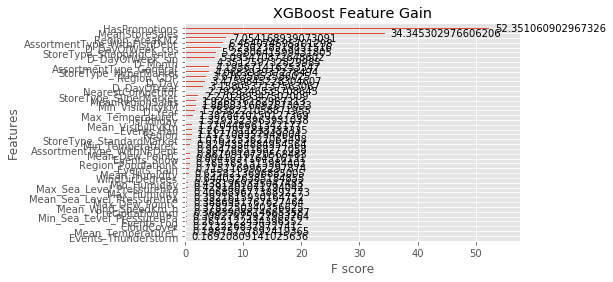

In [22]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

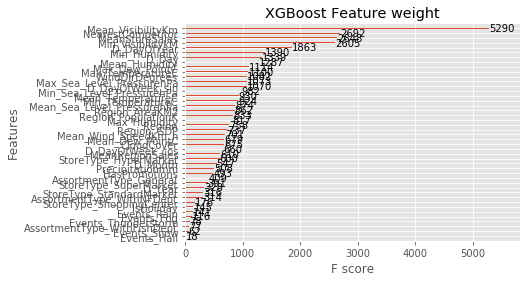

In [23]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

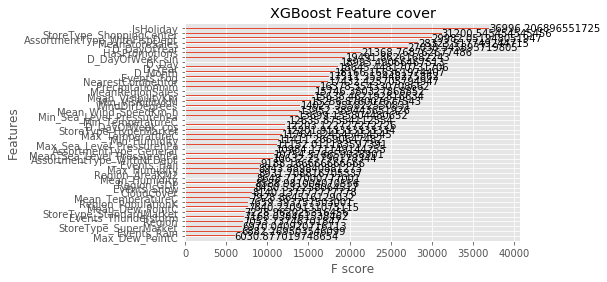

In [24]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [25]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [26]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

/home/nyxgear/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BIP Error

In [27]:
from BIP_error import get_BIP_error
error1 = get_BIP_error(test)

Number of regions identified: 11
BIP total error: 0.0432650660508975


In [28]:
diff=test['NumberOfSales']-test['_NumberOfSales']

In [29]:
diff.head(15).T

670   -1292.677734
671    2682.640625
672    -829.421875
674    -629.983887
675    -742.571777
677   -2778.169922
678   -2409.602539
679   -1549.103516
680   -1668.125000
681    -600.360352
682    -368.715332
684    -266.990234
685    1299.978027
686    -647.062500
687    -692.443359
dtype: float32

In [30]:
diff.mean()

5.6262359619140625

In [31]:
train_probs.shape

(36911,)

In [32]:
#test['predicted'] = pd.Series([train_probs], index=test.index)
#test['predicted']=train_probs

In [33]:
compare = test[['NumberOfSales','_NumberOfSales']]

### Saving TEST

In [34]:
#test.to_csv('./dataset/XGB5_fake_test.csv', index=False)

In [35]:
error = rmspe(test['_NumberOfSales'].values, test['NumberOfSales'].values)
print('error', error)

error 0.20609867165704734


In [36]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
14893,5468,6595.064941
14894,6795,6826.379883
14896,7035,6586.697754
14897,5437,5881.881348
14898,5725,5415.882324
14899,5143,5115.334473
14900,5589,6042.995117
14901,7520,6414.871094
14903,3927,4904.674805
14904,3682,4510.245605


In [37]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
14893,5468,6595.064941
14894,6795,6826.379883
14896,7035,6586.697754
14897,5437,5881.881348
14898,5725,5415.882324
14899,5143,5115.334473
14900,5589,6042.995117
14901,7520,6414.871094
14903,3927,4904.674805
14904,3682,4510.245605


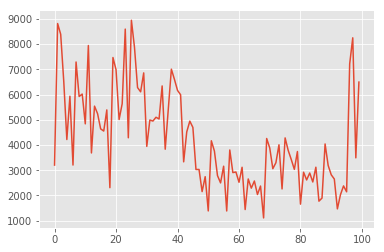

In [38]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

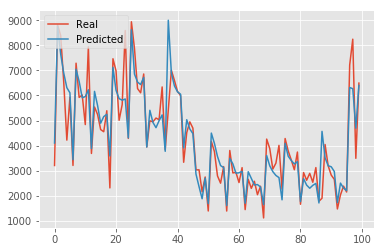

In [39]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

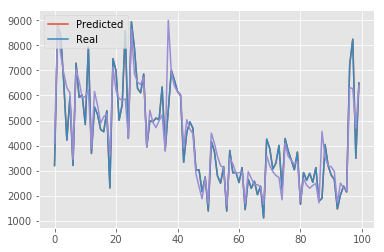

In [40]:
import matplotlib.pyplot as plt
#import matplotlib as mpl

#mpl.style.use("default")


plt.plot(x_coordinate,y)
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [41]:
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

ValueError: operands could not be broadcast together with shapes (19853,) (36911,) 

In [ ]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

In [ ]:
Y = df.iloc[:, 3]

In [ ]:
Y